# Landscape Evolution Modeling

A showcase of xarray-simlab in the context of landscape evolution modeling (an almost real world example).

In [1]:
import numpy as np
import xarray as xr
import xsimlab as xs

## Import and inspect a model

The model (i.e., the `xsimlab.Model` object) that we use here is provided by the [xarray-topo](https://gitext.gfz-potsdam.de/sec55-public/xarray-topo) package (**Note:** check the version of this package below, it may not correspond to the latest stable release).

In [2]:
import xtopo
print(xtopo.__version__)

v0.0.10+0.gb27cf6e.dirty


In [3]:
from xtopo.models.fastscape_base import fastscape_base_model

This model simulates the long-term evolution of topographic surface elevation (hereafter noted $h$) on a 2D regular grid. The local rate of elevation change, $\partial h/\partial t$, is determined by the balance between uplift (uniform in space and time) $U$ and erosion $E$.

$$\frac{\partial h}{\partial t} = U - E$$

Total erosion $E$ is the combined effect of the erosion of (bedrock) river channels, noted $E_r$, and erosion- transport on hillslopes, noted $E_d$

$$E = E_r + E_d$$

Erosion of river channels is given by the stream power law:

$$E_r = K_r A^m (\nabla h)^n$$

where $A$ is the drainage area and $K$, $m$ and $n$ are parameters.

Erosion on hillslopes is given by a linear diffusion law:

$$E_d = K_d \nabla^2 h$$

We can see these parameters - as well as the initial elevation surface and the grid parameters - as model inputs in the `repr`.

In [4]:
fastscape_base_model

<xsimlab.Model (10 processes, 11 inputs)>
grid
    y_size         [in] nb. of nodes in y
    y_length       [in] total grid length in y
    x_size         [in] nb. of nodes in x
    x_length       [in] total grid length in x
boundaries
block_uplift
    u_coef         [in] () or ('y', 'x') uplift rate
flow_routing
    pit_method     [in]
area
spower
    n_exp          [in] stream-power slope exponent
    k_coef         [in] stream-power constant
    m_exp          [in] stream-power drainage area exponent
diffusion
    k_coef         [in] diffusivity
erosion
uplift
topography
    elevation   [inout] ('y', 'x') topographic elevation

To have a better picture of all processes (and inputs and/or variables) in the model, we can visualize it as a graph. Processes are in blue and inputs are in yellow. The order in the graph corresponds to the order in which the processes will be exectued during a simulation.

Note: the visualization requires graphviz and python-graphviz packages (both can be installed using conda and the conda-forge channel).

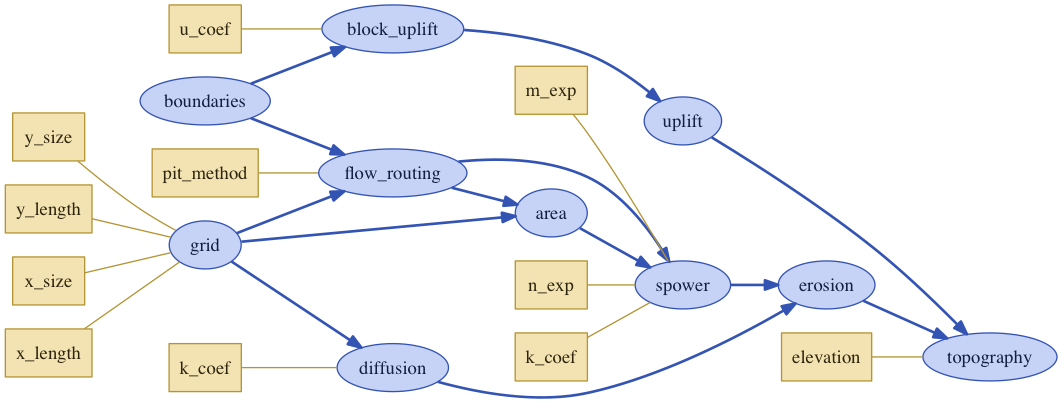

In [5]:
fastscape_base_model.visualize(show_inputs=True)

More information can be shown for each process in the model, e.g., for the grid

In [6]:
fastscape_base_model.grid

<Grid2D 'grid' (xsimlab process)>
Variables:
    x_size        [in] nb. of nodes in x
    y_size        [in] nb. of nodes in y
    x_length      [in] total grid length in x
    y_length      [in] total grid length in y
    x_spacing    [out]
    y_spacing    [out]
    x            [out] ('x',) 
    y            [out] ('y',) 
Simulation stages:
    initialize

## Create a model setup

We create a simulation setup using the `create_setup` function.

In [7]:
nx = 101
ny = 101

in_ds = xs.create_setup(
    model=fastscape_base_model,
    clocks={
        'time': {'end': 1e6, 'step': 1e4},
        'out': {'end': 1e6, 'step': 1e5}
    },
    master_clock='time',
    input_vars={
        'grid': {'x_size': nx, 'y_size': ny, 'x_length': 1e5, 'y_length' :1e5},
        'topography': {'elevation': (('y', 'x'), np.random.rand(ny, nx))},
        'flow_routing': {'pit_method': 'mst_linear'},
        'spower': {'k_coef': 7e-5, 'm_exp': 0.4, 'n_exp': 1},
        'diffusion': {'k_coef': 1.},
        'block_uplift': {'u_coef': 2e-3}
    },
    output_vars={
        'out': {'topography': 'elevation'},
        None: {'grid': ('x', 'y')}
    }
)

Some explanation about the arguments of `create_setup` and the values given above:

- we specify the model we want to use, here `fastscape_base_model`,
- we give some arguments in order to create clock coordinates (i.e., time coordinates),
- among these coordinates, we specify the master clock, i.e., the coordinate that will be used to
  set the time steps,
- we set values for model inputs, grouped by process in the model,
- we set the model variables for which we want to take snapshots during a simulation, grouped first
  by clock coordinate (`None` means that only one snapshot will be taken at the end of the simulation)
  and then by process.
  
Here above, we define a 'time' coordinate and another coordinate 'out' with much larger but aligned
time steps (the values are in years). 'time' will be used for the simulation time steps and 'out' will be used to take just a few, evenly-spaced snapshots of
variable 'elevation' in process 'topography'. We also want to
save the $x$ and $y$ coordinates of the grid (values in meters), which are time-invariant.

The initial conditions consist here of a nearly flat topographic surface with small random perturbations.

`create_setup` returns a `xarray.Dataset` object that contains everything we need to run the simulation. 

In [8]:
in_ds

<xarray.Dataset>
Dimensions:                   (out: 11, time: 101, x: 101, y: 101)
Coordinates:
  * time                      (time) float64 0.0 1e+04 2e+04 3e+04 4e+04 ...
  * out                       (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 ...
Dimensions without coordinates: x, y
Data variables:
    grid__x_size              int64 101
    grid__y_size              int64 101
    grid__x_length            float64 1e+05
    grid__y_length            float64 1e+05
    topography__elevation     (y, x) float64 0.7405 0.8413 0.5533 0.06639 ...
    flow_routing__pit_method  <U10 'mst_linear'
    spower__k_coef            float64 7e-05
    spower__m_exp             float64 0.4
    spower__n_exp             int64 1
    diffusion__k_coef         float64 1.0
    block_uplift__u_coef      float64 0.002
Attributes:
    __xsimlab_output_vars__:  grid__x,grid__y

If present, the metadata (e.g., description, units, math_symbol...) associated to each input variable in the model are added as attributes in the dataset, e.g.,

In [9]:
in_ds.spower__k_coef

<xarray.DataArray 'spower__k_coef' ()>
array(7e-05)
Attributes:
    description:  stream-power constant

## Run the model

We run the model simply by calling `in_ds.xsimlab.run()`, which returns a new Dataset with both the inputs and the outputs. 

In [10]:
out_ds = in_ds.xsimlab.run(model=fastscape_base_model)

out_ds

<xarray.Dataset>
Dimensions:                   (out: 11, time: 101, x: 101, y: 101)
Coordinates:
  * time                      (time) float64 0.0 1e+04 2e+04 3e+04 4e+04 ...
  * out                       (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 ...
Dimensions without coordinates: x, y
Data variables:
    grid__x_size              int64 101
    grid__y_size              int64 101
    grid__x_length            float64 1e+05
    grid__y_length            float64 1e+05
    topography__elevation     (out, y, x) float64 0.7405 0.8413 0.5533 ...
    flow_routing__pit_method  <U10 'mst_linear'
    spower__k_coef            float64 7e-05
    spower__m_exp             float64 0.4
    spower__n_exp             int64 1
    diffusion__k_coef         float64 1.0
    block_uplift__u_coef      float64 0.002
    grid__x                   (x) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
    grid__y                   (y) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...

Note in `out_ds` the `topography__elevation` variable which has now an additional `out` dimension and also the new variables `grid__x` and `grid__y`.

## Analyse, plot and save the results

The simulation input and output data is already in a format that allows us using all the nice features of xarray to further analyse, process, plot and/or write to disk (e.g., in a netCDF file) the data.

In this case for example, before doing any further processing it is more convenient to set $x$ and $y$ coordinates as coordinates of the output `Dataset` instead of data variables, using the `set_index` method. We can easily chain this method with `xsimlab.run` as it both return Dataset objects: 

In [11]:
out_ds = (in_ds
          .xsimlab.run(model=fastscape_base_model)
          .set_index(x='grid__x', y='grid__y'))

out_ds

<xarray.Dataset>
Dimensions:                   (out: 11, time: 101, x: 101, y: 101)
Coordinates:
  * time                      (time) float64 0.0 1e+04 2e+04 3e+04 4e+04 ...
  * out                       (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 ...
  * x                         (x) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * y                         (y) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
Data variables:
    grid__x_size              int64 101
    grid__y_size              int64 101
    grid__x_length            float64 1e+05
    grid__y_length            float64 1e+05
    topography__elevation     (out, y, x) float64 0.7405 0.8413 0.5533 ...
    flow_routing__pit_method  <U10 'mst_linear'
    spower__k_coef            float64 7e-05
    spower__m_exp             float64 0.4
    spower__n_exp             int64 1
    diffusion__k_coef         float64 1.0
    block_uplift__u_coef      float64 0.002

It is then easier to plot the simulation outputs, e.g., here below the elevation values at the end of the simulation:

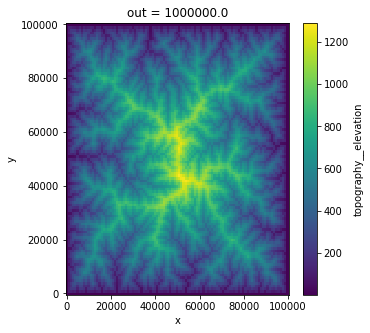

In [12]:
%matplotlib inline

xr.plot.pcolormesh(out_ds.isel(out=-1).topography__elevation,
                   size=5, aspect=1);

xarray datasets can be used with [Holoview](http://holoviews.org/), a plotting package that is really helpful for quickly and interactively exploring multi-dimensional data. (it can be installed using conda).

In [13]:
import holoviews as hv

hv.notebook_extension('matplotlib')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

We can for example see below how the relief is created during the simulation (snapshots are taken every 100000 years and elevation values are in meters).

**Note:** There may be issues with rendering Holoview interactive visualizations if you are on xarray-simlab's documentation. Fortunately you should be able to see this page as a notebook properly rendered on [nbviewer.org](http://nbviewer.jupyter.org/github/benbovy/xarray-simlab/blob/master/doc/examples/landscape-evolution-model.ipynb).

In [14]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_ds.topography__elevation)
hv_ds.to(hv.Image, ['x', 'y'])

:HoloMap   [out]
   :Image   [x,y]   (topography__elevation)

Additionally, We can compute derived quantities without much effort. Here below we calculate the surface denudation rates (in m/yr) averaged over each time steps of the output `out` dimension. 

In [15]:
def denudation_rate(ds, time_dim='out'):
    topo = ds.topography__elevation
    dt = ds[time_dim].diff(time_dim)
    den_rate = topo.diff(time_dim) / dt - ds.block_uplift__u_coef
    return den_rate

In [16]:
den_rate = denudation_rate(out_ds)

We further compute and plot the spatially averaged denudation rate.

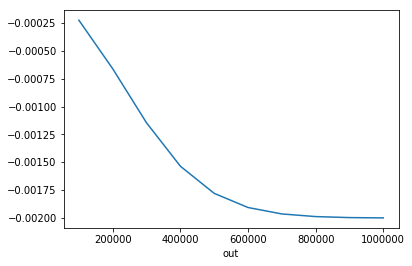

In [17]:
den_rate.mean(('x', 'y')).plot();

## Run the model with time-varying parameter values

Instead of providing constant, scalar values for model inputs, it is possible to provide arrays which have the same dimension as the one used for the "master clock" (the `time` dimension in this case).

As an example, we try below a sinusoidal variation for the $K$ parameter of the stream power law, with a period of 400000 years.

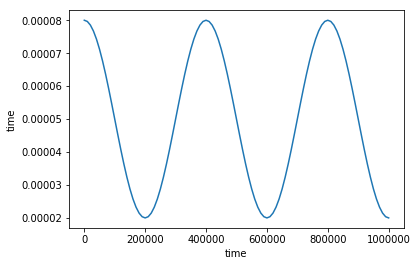

In [18]:
da_k_time = 5e-5 + 3e-5 * np.cos((2 * np.pi / 4e5) * in_ds.time)

da_k_time.plot();

We then re-use the simulation setup created above and only update the parameters of the stream-power process with the new values for $K$ (using `Dataset.xsimlab.update_vars`).

Note the `time` dimension of the `spower__k_coef` variable in the new returned Dataset.

In [19]:
in_ds_kt = in_ds.xsimlab.update_vars(
    model=fastscape_base_model,
    input_vars={'spower': {'k_coef': da_k_time, 'm_exp': 0.4, 'n_exp': 1}}
)

in_ds_kt

<xarray.Dataset>
Dimensions:                   (out: 11, time: 101, x: 101, y: 101)
Coordinates:
  * time                      (time) float64 0.0 1e+04 2e+04 3e+04 4e+04 ...
  * out                       (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 ...
Dimensions without coordinates: x, y
Data variables:
    grid__x_size              int64 101
    grid__y_size              int64 101
    grid__x_length            float64 1e+05
    grid__y_length            float64 1e+05
    topography__elevation     (y, x) float64 0.7405 0.8413 0.5533 0.06639 ...
    flow_routing__pit_method  <U10 'mst_linear'
    spower__k_coef            (time) float64 8e-05 7.963e-05 7.853e-05 ...
    spower__m_exp             float64 0.4
    spower__n_exp             int64 1
    diffusion__k_coef         float64 1.0
    block_uplift__u_coef      float64 0.002
Attributes:
    __xsimlab_output_vars__:  grid__x,grid__y

We then run the model, unstack the spatial dimensions, compute the denudation rates and plot the spatial averages, here again by easily chaining xarray and xarray-simlab methods on the input Dataset.

If we compare the results with those from the previous run, we clearly see the impact of the time-varying $K$ parameter values on the denudation rates. 

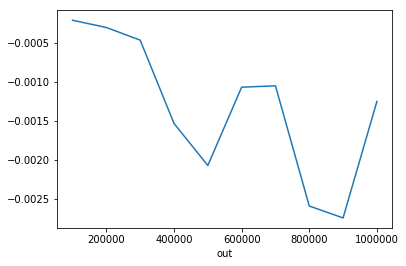

In [20]:
den_rate_kt = (in_ds_kt
               .xsimlab.run(model=fastscape_base_model)
               .set_index(x='grid__x', y='grid__y')
               .pipe(denudation_rate))

den_rate_kt.mean(('x', 'y')).plot();

## Run and combine different model setups

Here is an brief example of running the model multiple times for different fixed values of $K$ and then concatenate the results into a single dataset. In next versions of xarray-simlab, this process will be even simpler.

In [21]:
def run_model(k_value):
    print('run k=%f' % k_value)
    
    ivars = {'spower': {'k_coef': k_value, 'm_exp': 0.4, 'n_exp': 1}}
    
    out_ds = (in_ds
              .xsimlab.update_vars(model=fastscape_base_model,
                                   input_vars=ivars)
              .xsimlab.run(model=fastscape_base_model)
              .set_index(x='grid__x', y='grid__y'))
    
    return out_ds

 
out_ds_multi = xr.concat(
    [run_model(k) for k in (5e-5, 6e-5, 7e-5)],
    dim='spower__k_coef', data_vars='different'
)

run k=0.000050
run k=0.000060
run k=0.000070


Note the additional `spower__k_coef` dimension, which has its own coordinate with labels corresponding to the different $K$ values.

In [22]:
out_ds_multi

<xarray.Dataset>
Dimensions:                   (out: 11, spower__k_coef: 3, time: 101, x: 101, y: 101)
Coordinates:
  * time                      (time) float64 0.0 1e+04 2e+04 3e+04 4e+04 ...
  * out                       (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 ...
  * x                         (x) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * y                         (y) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * spower__k_coef            (spower__k_coef) float64 5e-05 6e-05 7e-05
Data variables:
    grid__x_size              int64 101
    grid__y_size              int64 101
    grid__x_length            float64 1e+05
    grid__y_length            float64 1e+05
    flow_routing__pit_method  <U10 'mst_linear'
    spower__m_exp             float64 0.4
    spower__n_exp             int64 1
    diffusion__k_coef         float64 1.0
    block_uplift__u_coef      float64 0.002
    topography__elevation     (spower__k_coef, out, y, x) float64 0.7405 ...

This new dimension also appears in the Holoview figure

In [23]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_ds_multi.topography__elevation)
hv_ds.to(hv.Image, ['x', 'y'])

:HoloMap   [out,spower__k_coef]
   :Image   [x,y]   (topography__elevation)

## Create an alternative version of the model

xarray-simlab makes it easy to create alternative versions of a model. In the example below, instead of using constant block uplift, we set a linear uplift function along the $x$ dimension. The first step is to create a new process, i.e., a Python class decorated by ``xsimlab.process``. 

In [24]:
from xtopo.models.fastscape_base import Grid2D, ClosedBoundaryFaces


@xs.process
class VariableUplift(object):
    """Compute spatially variable uplift as a linear function of x."""
    
    x_coef = xs.variable(description='uplift function x coefficient')
    
    active_nodes = xs.foreign(ClosedBoundaryFaces, 'active_nodes')
    x = xs.foreign(Grid2D, 'x')
    
    uplift = xs.variable(intent='out', group='uplift')

    def initialize(self):
        mask = self.active_nodes
        ny, nx = mask.shape

        u_rate = np.ones((ny, nx)) * self.x_coef * self.x[None, :]
        
        self._u_rate = np.zeros((ny, nx))
        self._u_rate[mask] = u_rate[mask]

    def run_step(self, dt):
        self.uplift = self._u_rate * dt


We then update the model that we used above with the new process (note the change in repr: the `uplift` process has now an `x_coef` input).

In [25]:
alt_model = (fastscape_base_model.drop_processes('block_uplift')
                                 .update_processes({'uplift_func': VariableUplift}))

alt_model

<xsimlab.Model (10 processes, 11 inputs)>
grid
    y_size         [in] nb. of nodes in y
    y_length       [in] total grid length in y
    x_size         [in] nb. of nodes in x
    x_length       [in] total grid length in x
boundaries
flow_routing
    pit_method     [in]
area
spower
    n_exp          [in] stream-power slope exponent
    k_coef         [in] stream-power constant
    m_exp          [in] stream-power drainage area exponent
diffusion
    k_coef         [in] diffusivity
erosion
uplift_func
    x_coef         [in] uplift function x coefficient
uplift
topography
    elevation   [inout] ('y', 'x') topographic elevation

We then re-use our intial setup, remove from this setup everything that is not related to the new model (using `Dataset.xsimlab.filter_vars` which here drops the `uplift__u_coef` variable), update the setup with the new parameter and then run the model.

Note that in some cases it is convenient to use the `with` statement with a `Model` object. For example we don't need to provide the `model` argument in `filter_vars`, `update_vars` and `run` methods below. 

In [26]:
with alt_model:
    out_ds_alt = (
        in_ds
        .xsimlab.filter_vars()
        .xsimlab.update_vars(input_vars={'uplift_func': {'x_coef': 1e-7}})
        .xsimlab.run()
        .set_index(x='grid__x', y='grid__y')
    )

You can compare the results obtained here with the results obtained above.

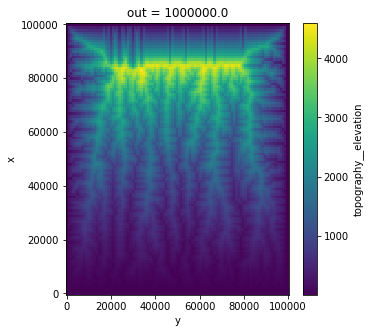

In [27]:
xr.plot.pcolormesh(out_ds_alt.isel(out=-1).topography__elevation.T,
                   size=5, aspect=1);

In [28]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_ds_alt.topography__elevation)
hv_ds.to(hv.Image, ['x', 'y'])

:HoloMap   [out]
   :Image   [x,y]   (topography__elevation)